# Example - Opportunity challenge.


#### Download and preprocess data

First, download the dataset for the opportunity challenge:

In [1]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00226/OpportunityUCIDataset.zip
! mkdir -p data/raw
! mv OpportunityUCIDataset.zip data/raw

--2020-11-12 13:19:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00226/OpportunityUCIDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306636009 (292M) [application/x-httpd-php]
Saving to: ‘OpportunityUCIDataset.zip’

OpportunityUCIDatas 100%[===================>] 292.43M  5.40MB/s    in 46s     

2020-11-12 13:20:22 (6.33 MB/s) - ‘OpportunityUCIDataset.zip’ saved [306636009/306636009]



Then, run the following script to preprocess the data. We generate seperate files for each run, to ensure that we can slide a window over the dataset without merging runs together, since this would confuse our LSTM. 

In [4]:
! python3 preprocess_data.py -s challenge

Checking dataset data/raw/OpportunityUCIDataset.zip
Processing dataset files ...
Generating training files
... file OpportunityUCIDataset/dataset/S1-Drill.dat -> train_data_0
... file OpportunityUCIDataset/dataset/S1-ADL1.dat -> train_data_1
... file OpportunityUCIDataset/dataset/S1-ADL2.dat -> train_data_2
... file OpportunityUCIDataset/dataset/S1-ADL3.dat -> train_data_3
... file OpportunityUCIDataset/dataset/S1-ADL4.dat -> train_data_4
... file OpportunityUCIDataset/dataset/S2-Drill.dat -> train_data_5
... file OpportunityUCIDataset/dataset/S2-ADL1.dat -> train_data_6
... file OpportunityUCIDataset/dataset/S2-ADL2.dat -> train_data_7
... file OpportunityUCIDataset/dataset/S3-Drill.dat -> train_data_8
... file OpportunityUCIDataset/dataset/S3-ADL1.dat -> train_data_9
... file OpportunityUCIDataset/dataset/S3-ADL2.dat -> train_data_10
... file OpportunityUCIDataset/dataset/S2-ADL3.dat -> train_data_11
... file OpportunityUCIDataset/dataset/S3-ADL3.dat -> train_data_12
Generating valid

#### Choose hyperparameters

First we choose the number of input channels, sliding window parameters, and the batch dimensions. We also define the initial learning rate and the number of epochs we want to train for, as well as how long we should train for after our validation metric stops improving (patience). Since we will use the Adam optimiser, which uses a dynamic, adaptive learning rate for each parameter in the network, the learning rate defined here represents the maximum value that the learning rate of any parameter can take. 

The batch size and batch length control the dimensions of the 'metabatches' which will be used to train the network, and num_batches represents the number of batches we will show to the network each epoch. The total number of windows shown to the network each epoch is therefore equal to num_batches * batch_size * batchlen, in this case 1,000,000. Since we only have around 500,000 windows in the dataset, this means that most unique windows will be shown to the network more than once each epoch, but at different positions in the batch.

This example is set to train for 10 epochs, to allow a quick demonstration.

In [1]:
n_channels = 113 # number of sensor channels
len_seq = 24 # Sliding window length
stride = 8 # Sliding window step
num_epochs = 10 # Max no. of epochs to train for
num_batches= 20 # No. of training batches per epoch. -1 means all windows will be presented at least once, up to batchlen times per epoch (unless undersampled)
batch_size = 1000 # Batch size / width - this many windows of data will be processed at once
patience= 20 # Patience of early stopping routine. If criteria does not decrease in this many epochs, training is stopped.
batchlen = 50 # No. of consecutive windows in a batch. If false, the largest number of windows possible is used.
val_batch_size = 1000 # Batch size for validation/testing. 
test_batch_size = 10000 # Useful to make this as large as possible given GPU memory, to speed up testing.
lr = 0.0001 # Initial (max) learning rate
num_batches_val = 1 # How many batches should we validate on each epoch
lr_step = 100

# Class names for opportunity dataset
opp_class_names = ['Null','Open Door 1','Open Door 2','Close Door 1','Close Door 2','Open Fridge',
'Close Fridge','Open Dishwasher','Close Dishwasher','Open Drawer 1','Close Drawer 1','Open Drawer 2','Close Drawer 2',
'Open Drawer 3','Close Drawer 3','Clean Table','Drink from Cup','Toggle Switch']

### Creating our DeepConvLSTM class.

Max pooling layers can be included if we want to work with a longer window length. These have the effect of allowing later convolutional layers to effectively look at longer temporal sequences in the input (by combining sequential ), while also reducing the dimensionality of the input allowing for faster operations. However, some fine-grained information could be lost in the transformation.

In [2]:
import torch
from torch import nn

## Define our DeepConvLSTM class, subclassing nn.Module.
class DeepConvLSTM(nn.Module):

    def __init__(self, n_hidden = 128, n_layers = 2, n_filters = 64,
                n_classes = 18, filter_size = 5,pool_filter_size=3, drop_prob = 0.5):

        super(DeepConvLSTM, self).__init__() # Call init function for nn.Module whenever this function is called

        self.drop_prob = drop_prob # Dropout probability
        self.n_layers = n_layers # Number of layers in the lstm network
        self.n_hidden = n_hidden # number of hidden units per layer in the lstm
        self.n_filters = n_filters # number of convolutional filters per layer
        self.n_classes = n_classes # number of target classes
        self.filter_size = filter_size # convolutional filter size
        self.pool_filter_size = pool_filter_size # max pool filter size if using

        # Convolutional net
        self.convlayer = nn.Sequential(
            nn.Conv1d(n_channels, n_filters, (filter_size)),
            # nn.MaxPool2d((pool_filter_size,1)), # Max pool layers, optional. 
            nn.Conv1d(n_filters, n_filters, (filter_size)),
            # nn.MaxPool2d((pool_filter_size,1)),
            nn.Conv1d(n_filters, n_filters, (filter_size)),
            nn.Conv1d(n_filters, n_filters, (filter_size))
            )

        # LSTM layers
        self.lstm = nn.LSTM(n_filters, n_hidden, n_layers, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(p=drop_prob)

        # Output layer
        self.predictor = nn.Linear(n_hidden,n_classes)


    def forward(self, x, hidden, batch_size):

        #Reshape x if necessary to add the 2nd dimension
        x = x.view(-1, n_channels, len_seq)
        x = self.convlayer(x)
        x = x.view(batch_size, -1, self.n_filters)

        x,hidden = self.lstm(x, hidden)

        x = self.dropout(x)

        x = x.view(batch_size, -1, self.n_hidden)[:,-1,:]
        out = self.predictor(x)

        return out, hidden

    def init_hidden(self, batch_size):

        weight = next(self.parameters()).data # return a Tensor from self.parameters to use as a base for the initial hidden state.
        
        ## Generate new tensors of zeros with similar type to weight, but different size.
        if (train_on_gpu):
            hidden = (weight.new_zeros(self.n_layers, batch_size, self.n_hidden).cuda(), # Hidden state
                  weight.new_zeros(self.n_layers, batch_size, self.n_hidden).cuda()) # Cell state
        else:
            hidden = (weight.new_zeros(self.n_layers, batch_size, self.n_hidden),
                      weight.new_zeros(self.n_layers, batch_size, self.n_hidden))

        return hidden

#### Create an instance of DeepConvLSTM called net.


In [3]:
net = DeepConvLSTM()

### Train the model


Weight decay should be proportional to batch size (larger batches = less updates) and inversely proportional to batch length (longer batches = more updates). We use a learning rate scheduler to decrease the maximum learning rate for all parameters after 100 epochs. This can allow for better fine tuning of parameters in later epochs, since the maximum distance the weights can move each step is reduced, leading to less jumping and potentially a more precise fit. We use the weighted cross-entropy loss so that samples of a highly represented class contribute less to the loss than 

In [6]:
import numpy as np
from utils import load_data, init_weights, EarlyStopping


X_train, y_train = load_data('train',len_seq,stride)
X_val, y_val = load_data('val',len_seq,stride)

net.apply(init_weights)

train_on_gpu = torch.cuda.is_available()

weight_decay = 1e-5*lr*batch_size*(50/batchlen)
opt = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=weight_decay,amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(opt,100) # Learning rate scheduler to reduce LR every 100 epochs

if(train_on_gpu):
    net.cuda()

train_stats = np.unique([a for y in y_train for a in y],return_counts=True)[1]
val_stats = np.unique([a for y in y_val for a in y],return_counts=True)[1]

print('Training set statistics:')
print(len(train_stats),'classes with distribution',train_stats)
print('Validation set statistics:')
print(len(val_stats),'classes with distribution',val_stats)

weights = torch.tensor([max(train_stats)/i for i in train_stats])

if train_on_gpu:
    weights = weights.cuda()
    
criterion = nn.CrossEntropyLoss(weight=weights)

val_criterion = nn.CrossEntropyLoss()

early_stopping = EarlyStopping(patience=patience, verbose=False)


['data/train_data_12', 'data/train_data_0', 'data/train_data_8', 'data/train_data_5', 'data/train_data_11', 'data/train_data_1', 'data/train_data_2', 'data/train_data_7', 'data/train_data_9', 'data/train_data_4', 'data/train_data_6', 'data/train_data_10', 'data/train_data_3']
Got (26717, 113) samples from data/train_data_12
Got (54966, 113) samples from data/train_data_0
Got (70928, 113) samples from data/train_data_8
Got (53398, 113) samples from data/train_data_5
Got (34232, 113) samples from data/train_data_11
Got (51116, 113) samples from data/train_data_1
Got (32224, 113) samples from data/train_data_2
Got (30182, 113) samples from data/train_data_7
Got (37223, 113) samples from data/train_data_9
Got (32955, 113) samples from data/train_data_4
Got (42797, 113) samples from data/train_data_6
Got (27825, 113) samples from data/train_data_10
Got (33273, 113) samples from data/train_data_3
['data/val_data_0']
Got (30127, 113) samples from data/val_data_0
Training set statistics:
18 cl

The function iterate_minibatches_2D returns sequential batches sampled from the training dataset in such a way that there is no possibility of discontinuities in the data being fed to the LSTM. Each iteration, the inputs and targets in the batch are returned, along with the position of the batch in the 2D 'metabatch'. In this way we can train the LSTM on short windows but retain information in the hidden and cell states of the LSTM relating to the previous windows in the metabatch, and we can choose the length of the metabatch. 

After each iteration, we update the weights and biases of the convolutional and LSTM layers by calling loss.backward(), but we retain the information in the hidden and cell states of the LSTM. When we have reached the end of the metabatch, we re-initialise the hidden and cell states to zero, to prevent cross-contamination between parts of the dataset that are not directly contiguous. 

After each epoch, we evaluate the trained network on the validation set and report some performance metrics - the loss, accuracy, weighted f1 score (where we first compute the f1 score for each class, then weight by the number of samples in the class and combine) and macro f1 score (where we take the average over the f1 scores of each class without considering weights). We also report the training loss. 

In [11]:
from utils import iterate_minibatches_2D
from datetime import datetime
import sklearn.metrics as metrics
import csv

print('Starting training at',datetime.now())
start_time=datetime.now()


with open('log.csv', 'w', newline='') as csvfile: # We will save some training statistics to plot a loss curve later.

    for e in range(num_epochs):

        train_losses = []
        net.train() # Setup network for training

        for batch in iterate_minibatches_2D(X_train, y_train, batch_size, stride, shuffle=True, num_batches=num_batches, batchlen=batchlen, drop_last=True):

            x,y,pos= batch

            inputs, targets = torch.from_numpy(x), torch.from_numpy(y) # Get torch tensors.


            opt.zero_grad() # Clear gradients in optimizer

            if pos==0:
                h = net.init_hidden(inputs.size()[0]) # If we are at the beginning of a metabatch, init lstm hidden states.

                
            h = tuple([each.data for each in h])  # Get rid of gradients attached to hidden and cell states of the LSTM
            
            if train_on_gpu:
                inputs,targets = inputs.cuda(),targets.cuda()
                


            output, h = net(inputs,h,inputs.size()[0]) # Run inputs through network

            loss = criterion(output.double(), targets.long()) 
            loss.backward()
            opt.step()

            train_losses.append(loss.item())


        val_losses = []
        net.eval() # Setup network for evaluation

        top_classes = []
        targets_cumulative = []

        
        with torch.no_grad():
            for batch in iterate_minibatches_2D(X_val, y_val, val_batch_size, stride, shuffle=True, num_batches=num_batches_val, batchlen=batchlen, drop_last=False):

                x,y,pos=batch


                inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

                targets_cumulative.extend([y for y in y])

                if pos == 0:
                    val_h = net.init_hidden(inputs.size()[0]) # Init lstm at start of each metabatch

                if train_on_gpu:
                    inputs,targets = inputs.cuda(),targets.cuda()

                output, val_h = net(inputs,val_h,inputs.size()[0])

                val_loss = val_criterion(output, targets.long())
                val_losses.append(val_loss.item())

                top_p, top_class = output.topk(1,dim=1)
                top_classes.extend([top_class.item() for top_class in top_class.cpu()])

        equals = [top_classes[i] == target for i,target in enumerate(targets_cumulative)]
        accuracy = np.mean(equals)

        f1score = metrics.f1_score(targets_cumulative, top_classes, average='weighted')
        f1macro = metrics.f1_score(targets_cumulative, top_classes, average='macro')

        scheduler.step()

        print('Epoch {}/{}, Train loss: {:.4f}, Val loss: {:.4f}, Acc: {:.2f}, f1: {:.2f}, Macro f1: {:.2f}'.format(e+1,num_epochs,np.mean(train_losses),np.mean(val_losses),accuracy,f1score,f1macro))


        writer = csv.writer(csvfile, delimiter=' ',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([np.mean(train_losses),np.mean(val_losses),accuracy,f1score,f1macro])
        
        early_stopping(np.mean(val_losses), net)
        if early_stopping.early_stop:
            print("Stopping training, validation loss has not decreased in {} epochs.".format(patience))
            break





print('Training finished at ',datetime.now())
print('Total time elapsed during training:',(datetime.now()-start_time).total_seconds(),'seconds')


Starting training at 2020-11-12 14:35:44.934744
Epoch 1/10, Train loss: 1.6412, Val loss: 1.9167, Acc: 0.29, f1: 0.35, Macro f1: 0.28
Epoch 2/10, Train loss: 0.7575, Val loss: 1.2387, Acc: 0.52, f1: 0.60, Macro f1: 0.42
Epoch 3/10, Train loss: 0.4905, Val loss: 0.9010, Acc: 0.70, f1: 0.75, Macro f1: 0.49
Epoch 4/10, Train loss: 0.3633, Val loss: 1.0666, Acc: 0.67, f1: 0.72, Macro f1: 0.54
Epoch 5/10, Train loss: 0.2880, Val loss: 0.8370, Acc: 0.73, f1: 0.78, Macro f1: 0.54
Epoch 6/10, Train loss: 0.2312, Val loss: 0.9530, Acc: 0.72, f1: 0.77, Macro f1: 0.58
Epoch 7/10, Train loss: 0.1942, Val loss: 0.7325, Acc: 0.77, f1: 0.81, Macro f1: 0.63
Epoch 8/10, Train loss: 0.1700, Val loss: 0.6006, Acc: 0.81, f1: 0.84, Macro f1: 0.62
Epoch 9/10, Train loss: 0.1485, Val loss: 0.9267, Acc: 0.74, f1: 0.79, Macro f1: 0.58
Epoch 10/10, Train loss: 0.1280, Val loss: 0.7945, Acc: 0.77, f1: 0.81, Macro f1: 0.64
Training finished at  2020-11-12 14:50:59.932807
Total time elapsed during training: 914.99

#### Test the model and display the results

Finally we iterate through every possible combination of windows in the testing set and report the precision, recall and f1 score of each class using sklearn, then produce a confusion matrix and plot with seaborn. 

['data/test_data_3', 'data/test_data_0', 'data/test_data_2', 'data/test_data_1']
Got (26495, 113) samples from data/test_data_3
Got (32748, 113) samples from data/test_data_0
Got (27681, 113) samples from data/test_data_2
Got (31826, 113) samples from data/test_data_1
Starting testing at 2020-11-12 14:53:48.940749
Finished testing at 2020-11-12 14:53:50.658819
Total time elapsed during testing: 1.718225 seconds
---- TESTING REPORT ----
                  precision    recall  f1-score   support

            Null       0.92      0.79      0.85     12317
     Open Door 1       0.26      0.14      0.18        84
     Open Door 2       0.26      0.28      0.27       143
    Close Door 1       0.22      0.57      0.32        89
    Close Door 2       0.25      0.40      0.30       124
     Open Fridge       0.21      0.48      0.30       340
    Close Fridge       0.17      0.05      0.08       233
 Open Dishwasher       0.10      0.16      0.12       144
Close Dishwasher       0.11      0.12

<AxesSubplot:>

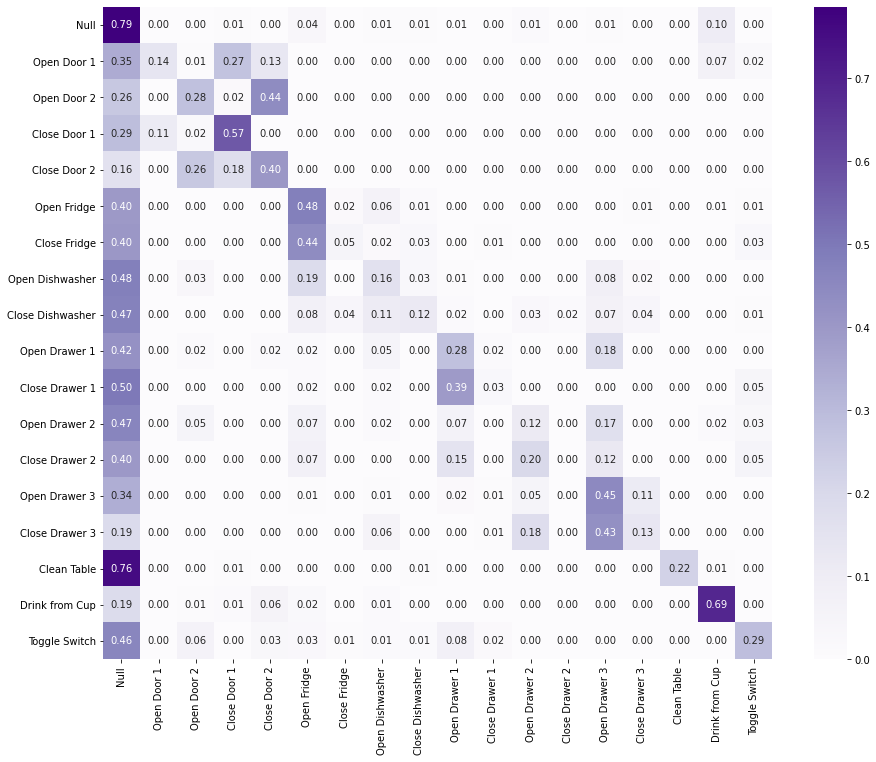

In [13]:
### Test the model
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from utils import iterate_minibatches_test

X_test, y_test = load_data('test',len_seq,stride)

print('Starting testing at', datetime.now())
start_time=datetime.now()
criterion = nn.CrossEntropyLoss()

if(train_on_gpu):
    net.cuda()

net.eval()

val_losses = []
accuracy=0
f1score=0
f1macro=0
targets_cumulative = []
top_classes = []


with torch.no_grad():

    for batch in iterate_minibatches_test(X_test, y_test, len_seq, stride=1):



        x,y,pos=batch



        inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

        targets_cumulative.extend([y for y in y])




        if(train_on_gpu):
            targets,inputs = targets.cuda(),inputs.cuda()

        if pos == 0:
            test_h = net.init_hidden(inputs.size()[0])



        output, test_h = net(inputs,test_h,inputs.size()[0])

        val_loss = criterion(output, targets.long())
        val_losses.append(val_loss.item())

        top_p, top_class = output.topk(1,dim=1)
        top_classes.extend([p.item() for p in top_class])




print('Finished testing at', datetime.now())
print('Total time elapsed during testing:', (datetime.now()-start_time).total_seconds(),'seconds')

f1score = metrics.f1_score(targets_cumulative, top_classes, average='weighted')

classreport = classification_report(targets_cumulative, top_classes,target_names=opp_class_names)
confmatrix = confusion_matrix(targets_cumulative, top_classes,normalize='true')
print('---- TESTING REPORT ----')
print(classreport)

df_cm = pd.DataFrame(confmatrix, index=opp_class_names,columns=opp_class_names)
plt.figure(10,figsize=(15,12))
sn.heatmap(df_cm,annot=True,fmt='.2f',cmap='Purples')


The true class is shown on the y axis and the predicted class on the x axis. The numbers represent the proportion of windows with the true label which were classified as the predicted label (i.e. the diagonal line corresponds to the recall of each class). 

Finally we can plot the training data we saved in the csv file:

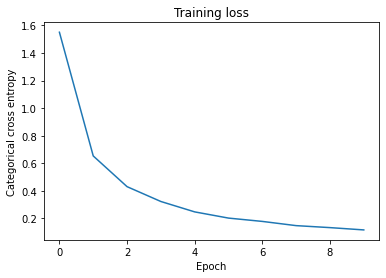

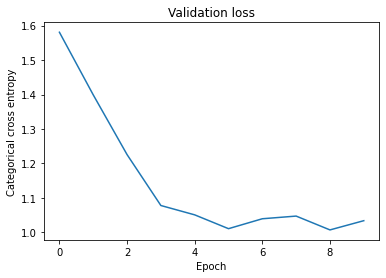

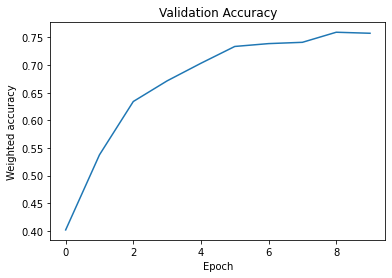

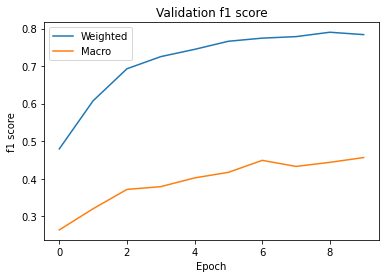

In [39]:
from utils import plot_data

plot_data()